In [15]:
# default_exp analyses

In [16]:
#| code-summary: -- load dependencies and data and select parameters
#| output: asis

analysis_overview = """
# Conditional Recall Probability by Semantic Distance
"""

analysis_tag = 'semcrp'
language_models = ['average_word_embeddings_glove.6B.300d']

data_paths = ["../../data/CDCATBEH.csv", 
    "../../data/HealyKahana2014.csv", "../../data/narrative/psifr_sbs.csv"]
trial_queries = [
    ["list_type == 'light'", "list_type == 'heavy'"], 
    ["task == -1", "task == 0", "task == 1", "task == 2"],
     ["story_index == {}".format(i) for i in range(1,6)],
]
query_labels = trial_queries
query_labels[-1] = ["story_name == '{}'".format(story) for story in [
    'Fisherman', 'Supermarket', 'Flight', 'Cat', 'Fog', 'Beach']]

show_figure = True
regenerate_figure = True
section_tags = ["CDCATBEH", "HealyKahana2014", "BrownSchmidt2019"]
figures_path = "figures/"
figure_caption = """The semantic contiguity effect measured as a function of task using data from @{} and the distance-CRP analysis."""

print(analysis_overview)


# Conditional Recall Probability by Semantic Distance



In [ ]:
# export
from sentence_transformers import SentenceTransformer
import json

class Language_Model:

    def __init__(self, model_name=None, dictionary_path=None):
        self.encoder = SentenceTransformer(model_name)
        if dictionary_path is not None:
            with open(dictionary_path, 'r') as f:
                self.dictionary = json.load(f)
    
    def encode(self, sentence):
        if sentence not in self.dict:
            self.dictionary[sentence] = self.encoder.encode(sentence)
        return self.dictionary[sentence]

    def close(self):
        with open('dictionary.json', 'w') as f:
            json.dump(self.dictionary, f)

In [18]:
# export
#| code-summary: -- specify semantic contiguity effect analysis code

from compmemlearn.datasets import events_metadata, generate_trial_mask
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from sentence_transformers import util
from numba import njit

@njit(nogil=True)
def fast_sem_crp(trials, distances, item_count, edges):
    
    total_actual_transitions = np.zeros(len(edges))
    total_possible_transitions = np.zeros(len(edges))
    terminus = np.sum(trials != 0, axis=1)

    # tabulate bin totals for actual and possible distance transitions
    for trial_index in range(len(trials)):
        previous_item = 0
        possible_items = np.arange(item_count)

        # track possible and actual transitions across recalls
        for recall_index in range(terminus[trial_index]):
            current_item = trials[trial_index, recall_index]-1

            if recall_index > 0:

                # compute edge bin for distance between previous and each possible item
                index = 0
                for possible_index in range(len(possible_items)):
                    possible_item = possible_items[possible_index]
                    distance = distances[trial_index, possible_item, previous_item]
                    distance_bin = np.sum(edges < distance, dtype=np.int32)
                    total_possible_transitions[distance_bin] += 1
                    if possible_item == current_item:
                        total_actual_transitions[distance_bin] += 1

            # update pool to exclude recalled item (updated to still identify 1-indexed item)
            previous_item = current_item
            possible_items = possible_items[possible_items != previous_item]

    return total_actual_transitions/total_possible_transitions

In [19]:
# export
#| code-summary: -- specify semantic contiguity effect plotting code

def plot_sem_crp(
    data, trial_query, language_model, contrast_name=None, labels=None, axis=None):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    if contrast_name is None:
        column_name = ''
    else:
        column_name = contrast_name

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, _, item_strings = events_metadata(events)[:4]
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        trial_mask = trial_mask[chose]
        item_strings = item_strings[chose]

        # set edges based on distances between unique item_strings in current dataset
        if data_index == 0:
            embeddings = language_model.encode(pd.unique(events.item_string))
            distances = 1-util.pytorch_cos_sim(embeddings, embeddings).numpy()
            distances[np.eye(len(distances), dtype=int)] = np.nan
            edges = np.nanpercentile(distances, np.linspace(1, 100, 10))

        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            # compute distances over sampled trials
            item_count = np.shape(item_strings)[1]
            distances = np.zeros((np.sum(subject_specific_trial_mask), item_count, item_count))
            for trial_index, trial in enumerate(trials[subject_specific_trial_mask]):
                embeddings = language_model.encode(item_strings[subject_specific_trial_mask][trial_index])
                cosine_scores = 1-util.pytorch_cos_sim(embeddings, embeddings).numpy()
                np.fill_diagonal(cosine_scores, np.nan)
                distances[trial_index, :len(embeddings), :len(embeddings)] = cosine_scores
                
            res = fast_sem_crp(trials[subject_specific_trial_mask], distances, item_count, edges)
            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "bin": edges,
                    "prob": res,
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result).reset_index()
    sns.lineplot(ax=axis, data=result, x='bin', y='prob', err_style='bars', hue=contrast_name, legend=False)
    axis.set(xlabel='Semantic Distance', ylabel='Conditional Recall Rate')

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis, result

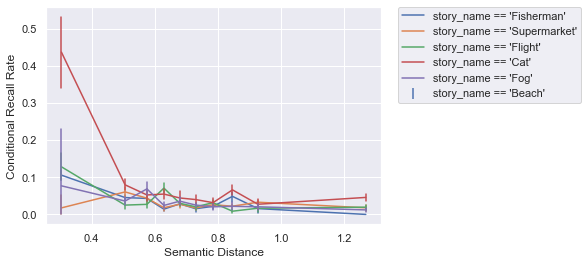

In [20]:
sns.set(style='darkgrid')

for i in range(len(data_paths)):
    section_tag = section_tags[i]
    trial_query = trial_queries[i]
    query_label = query_labels[i]
    data_path = data_paths[i]

    if regenerate_figure or show_figure:
        ax = None
        for query in trial_query:

            events = pd.read_csv(data_path)
            ax = plot_sem_crp([events], query, model, labels=[query], axis=ax)[0]

        ax.legend(query_labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        if regenerate_figure:
            plt.savefig(
                figures_path+f'{section_tag}_{analysis_tag}.pdf', bbox_inches="tight")
                
        if show_figure:
            plt.show()
        else:
            print(
                f"""::: {{#fig-{section_tag}_{analysis_tag} layout-valign="center"}}
                
![]({figures_path}{section_tag}_{analysis_tag}.pdf)

{figure_caption}
:::""");
        plt.close()

    else:
        if not os.path.isfile(f'{figures_path}{section_tag}_{analysis_tag}.pdf'):
            print(
                f'Figure not found at {figures_path}{section_tag}_{analysis_tag}.pdf. Run with regenerate_figure=True to generate.')
        else:
            print(
                f"""::: {{#fig-{section_tag}_{analysis_tag} layout-valign="center"}}
                
![]({figures_path}{section_tag}_{analysis_tag}.pdf)

{figure_caption}
:::""");
    break

In [21]:
# %load_ext line_profiler
# %lprun -f plot_sem_crp plot_sem_crp([events], query, model, labels=[query])